In [13]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import json
import joblib as joblib

import re
import string

In [14]:
# nltk.download('punkt')
# pip install unidecode
from unidecode import unidecode

In [15]:
# Load data
data_train = pd.read_csv('../../Data Splits/train_data_70_30.csv')
data_test = pd.read_csv('../../Data Splits/test_data_70_30.csv')

X_train = data_train['article']
y_train = data_train['label']

X_test = data_test['article']
y_test = data_test['label']

In [16]:
# Stopword Removal
ps = PorterStemmer()
with open('../../Datasets/stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)
    
def preprocess(text):
    if isinstance(text, str):  # If it's a single string
        text = [text]  # Convert to a list of one string for consistency

    processed_texts = []
    for item in text:
        # Lowercase Conversion
        lowered = item.lower()

        # URL Removal
        urled = re.sub(r'https?://\S+|www\.\S+', '', lowered)
        
        # Text Simplification
        simplified = re.sub(r'\[.*?\]', '', urled)
        simplified = re.sub(r"\\W", " ", simplified)
        simplified = re.sub(r'<.*?>+', '', simplified)
        simplified = re.sub(r'[%s]' % re.escape(string.punctuation), '', simplified)
        simplified = re.sub(r'\n', '', simplified)
        simplified = re.sub(r'\w*\d\w*', '', simplified)

        # Tokenization
        tokens = nltk.word_tokenize(simplified)
        stems = [ps.stem(token) for token in tokens]
        filtered = [stem for stem in stems if stem not in stopwords]
        
        processed_texts.append(filtered)

    if len(processed_texts) == 1:
        return processed_texts[0]  # Return the single processed text
    else:
        return processed_texts  # Return the list of processed texts


In [17]:
# Apply preprocess function to X_train
X_train_preprocessed = X_train.apply(preprocess)

# Apply preprocess function to X_val
X_test_preprocessed = X_test.apply(preprocess)

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train_preprocessed.apply(lambda x: ' '.join(x)))
X_test_tfidf = vectorizer.transform(X_test_preprocessed.apply(lambda x: ' '.join(x)))

In [18]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

# mnb = MultinomialNB(alpha= 0.1, fit_prior=False)
# lr = LogisticRegression(C= 100, penalty= 'l2', solver= 'liblinear')
# rf = RandomForestClassifier(n_estimators= 300, random_state=42)
# knn = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 5, weights= 'uniform')
# svm = SVC(C=10, degree=2, kernel = 'linear', probability = True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']

In [19]:
stack_rf = joblib.load('../../ModelsV3/stackmodel_rf.joblib')
stack_lr = joblib.load('../../ModelsV3/stackmodel_lr.joblib')
stack_svm = joblib.load('../../ModelsV3/stackmodel_svm.joblib')
stack_mlp = joblib.load('../../ModelsV3/stackmodel_mlp.joblib')

models = [
    (stack_lr, 'Logistic Regression'),
    (stack_rf, 'Random Forest'),
    (stack_svm, 'Support Vector Machine'),
    (stack_mlp, 'Multi-layer Perceptron'),
]

In [20]:
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']
metrics_df = pd.DataFrame(index=base_names, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])


# Evaluate base models
for model, name in  zip(base_models, base_names):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_train_tfidf)
    y_prob = model.predict_proba(X_train_tfidf)[:, 1]  # Probability for positive class for ROC curve
    
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    auc = roc_auc_score(y_train, y_prob)

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]


# Evaluate stacking models
def get_performance_stats(model, name):
    stack_y_pred = model.predict(X_train_tfidf)
    stack_y_prob = model.predict_proba(X_train_tfidf)[:, 1]

    stack_accuracy = accuracy_score(y_train, stack_y_pred)
    stack_precision = precision_score(y_train, stack_y_pred)
    stack_recall = recall_score(y_train, stack_y_pred)
    stack_f1 = f1_score(y_train, stack_y_pred)
    stack_auc = roc_auc_score(y_train, stack_y_prob)
    metrics_df.loc[name] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]

metrics_df.loc['Stacking Model'] = ["", "", "", "", ""]

for model, name in models:
    get_performance_stats(model, name)

# Display the comparison table
print("Comparison of Models: (TRAINING)")
print(metrics_df)

Comparison of Models: (TRAINING)
                        Accuracy Precision    Recall  F1 Score       AUC
MNB                     0.946267  0.907519  0.994318  0.948938  0.995986
LR                      0.976224  0.993137   0.95928  0.975915   0.99903
RF                           1.0       1.0       1.0       1.0       1.0
KNN                     0.901569   0.85523  0.967803  0.908041  0.980361
SVM                          1.0       1.0       1.0       1.0       1.0
Stacking Model                                                          
Logistic Regression          1.0       1.0       1.0       1.0       1.0
Random Forest                1.0       1.0       1.0       1.0       1.0
Support Vector Machine       1.0       1.0       1.0       1.0       1.0
Multi-layer Perceptron       1.0       1.0       1.0       1.0       1.0


Comparison of Models: (TESTING)
                        Accuracy Precision    Recall  F1 Score       AUC
MNB                     0.837029  0.760204  0.986755   0.85879  0.976838
LR                      0.932373  0.953704  0.909492  0.931073  0.983894
RF                      0.932373  0.947489  0.916115  0.931538  0.983827
KNN                      0.85255  0.800752  0.940397  0.864975  0.943726
SVM                      0.94235  0.973995  0.909492  0.940639  0.988456
Stacking Model                                                          
Logistic Regression     0.961197  0.960352  0.962472  0.961411  0.992522
Random Forest           0.962306  0.956427  0.969095  0.962719  0.993446
Support Vector Machine   0.95898  0.962222   0.95585  0.959025  0.991937
Multi-layer Perceptron   0.95122  0.945534  0.958057  0.951754  0.991588


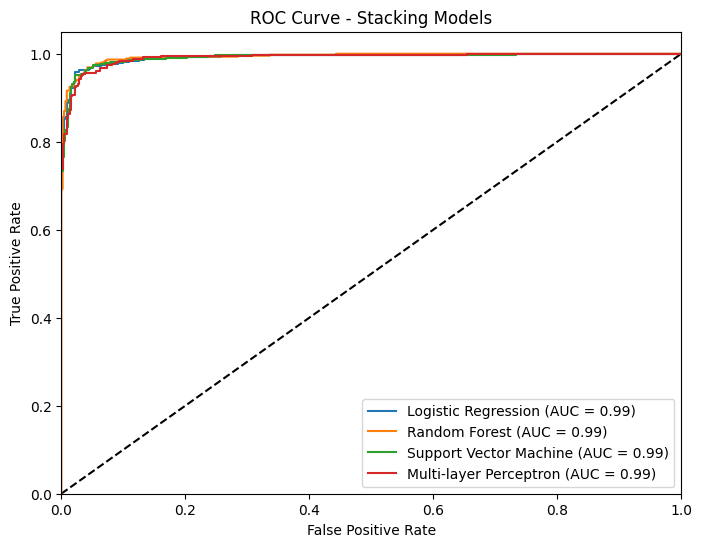

In [24]:
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']
metrics_df = pd.DataFrame(index=base_names, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])


# Evaluate base models
for model, name in  zip(base_models , base_names):
    y_pred = model.predict(X_test_tfidf)
    y_prob = model.predict_proba(X_test_tfidf)[:, 1]  # Probability for positive class for ROC curve
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

# Initialize the figure
plt.figure(figsize=(8, 6))

# Plot the baseline of a random classifier
plt.plot([0, 1], [0, 1], 'k--')

# Evaluate stacking models
def get_performance_stats(model, name):
    stack_y_pred = model.predict(X_test_tfidf)
    stack_y_prob = model.predict_proba(X_test_tfidf)[:, 1]  

    stack_accuracy = accuracy_score(y_test, stack_y_pred)
    stack_precision = precision_score(y_test, stack_y_pred)
    stack_recall = recall_score(y_test, stack_y_pred)
    stack_f1 = f1_score(y_test, stack_y_pred)
    stack_auc = roc_auc_score(y_test, stack_y_prob)
    metrics_df.loc[name] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]

    stack_fpr, stack_tpr, _ = roc_curve(y_test, stack_y_prob)
    stack_roc_auc = roc_auc_score(y_test, stack_y_prob)

    plt.plot(stack_fpr, stack_tpr, label=f'{name} (AUC = {stack_roc_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Stacking Models')
    plt.legend(loc="lower right")

metrics_df.loc['Stacking Model'] = ["", "", "", "", ""]

for model, name in models:
    get_performance_stats(model, name)

# Display the comparison table
print("Comparison of Models: (TESTING)")
print(metrics_df)